# Multi Tone (Call WA)

Import Library

In [1]:
import numpy as np
import librosa
from scipy.io import wavfile
from IPython.display import Audio
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import sounddevice as sd
import librosa.display
import pandas as pd

## Pre-processing Audio

Convert audio ke mono dan normalisasi amplitudo

In [2]:
file_audio = "09_call WA.wav"

sr, audio = wavfile.read(file_audio)

if audio.dtype == np.uint16:
    audio = audio.astype(np.float32)
    audio = (audio - 32768) / 32768.0

elif audio.dtype == np.int16:
    audio = audio.astype(np.float32) / 32768.0

if len(audio.shape) > 1:
    audio = audio[:, 0]

Audio(audio, rate=sr)

Hasil Normalisasi

In [3]:
print(np.min(audio), np.max(audio))
print(audio[:20])

-0.3314209 0.3397522
[0.07693481 0.07675171 0.07672119 0.07669067 0.07644653 0.07571411
 0.07458496 0.07318115 0.07150269 0.0696106  0.06738281 0.06481934
 0.06225586 0.05960083 0.05682373 0.0541687  0.05108643 0.04751587
 0.04360962 0.0390625 ]


Panjang durasi audio dan jumlah sampel sinyal per detiknya

In [4]:
print("Sample Rate:", sr)
print("Durasi Audio:", len(audio)/sr, "detik")

Sample Rate: 48000
Durasi Audio: 61.06 detik


Cek noise pada data audio

In [5]:
# Ambil 10% sampel amplitudo terkecil sebagai noise
portion = int(len(audio) * 0.1)
idx = np.argsort(np.abs(audio))[:portion]
noise_signal = audio[idx]

print("Noise samples:", len(noise_signal))

Noise samples: 293088


Menangani noise pada data audio

Jumlah frame mencurigakan: 184


C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


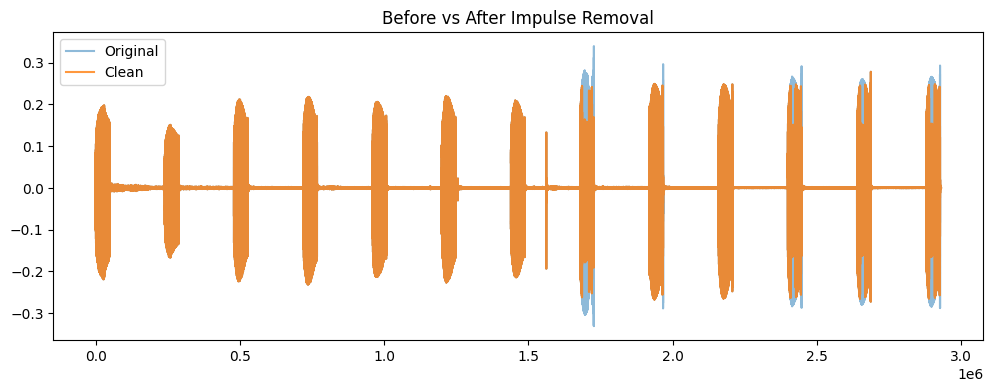

In [6]:
#frame hitung energi
frame = int(0.02 * sr) 
step = frame // 2     
energies = []

for i in range(0, len(audio) - frame, step):
    energies.append(np.sum(audio[i:i+frame]**2))
energies = np.array(energies)

# Tentukan ambang tinggi (kandidat impuls)
threshold = np.percentile(energies, 97)  # ambil energi atas 3%
imp_idx = np.where(energies > threshold)[0]

print(f"Jumlah frame mencurigakan: {len(imp_idx)}")

#smoothing (fade) pada frame
clean_audio = audio.copy()

def fade_segment(x, start, end):
    fade_len = end - start
    fade = np.linspace(1, 0.2, fade_len)  # turunkan amplitudo
    x[start:end] *= fade
    return x

for idx in imp_idx:
    start = idx * step
    end = min(start + frame, len(clean_audio))
    clean = fade_segment(clean_audio, start, end)

#Visualisasi sebelum–sesudah
plt.figure(figsize=(12,4))
plt.plot(audio, alpha=0.5, label='Original')
plt.plot(clean_audio, alpha=0.8, label='Clean')
plt.legend()
plt.title("Before vs After Impulse Removal")
plt.show()

Estimasi noise sederhana

In [7]:
signal_energy = np.sum(clean_audio**2) 
portion = int(len(clean_audio)*0.10)
noise_energy = np.sum(np.sort(np.abs(clean_audio))[:portion]**2)
snr = 10 * np.log10(signal_energy / noise_energy)

print(f"\nEstimasi Tingkat Noise")
print(f"Signal Energy   : {signal_energy:.4f}")
print(f"Noise Energy    : {noise_energy:.4f}")
print(f"Estimasi SNR(dB): {snr:.2f} dB")


Estimasi Tingkat Noise
Signal Energy   : 10850.2285
Noise Energy    : 0.0007
Estimasi SNR(dB): 71.87 dB


Visualisasi Waveform

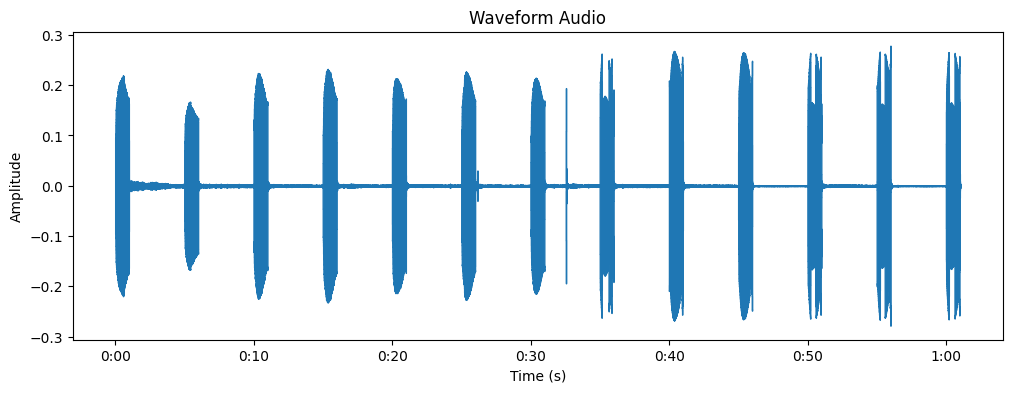

In [8]:
plt.figure(figsize=(12,4))
librosa.display.waveshow(clean_audio, sr=sr)
plt.title("Waveform Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

## Metoded FFT (Fast Fourier Transform)

In [9]:
N = len(clean_audio)
fft_spectrum = np.fft.fft(clean_audio)
fft_freq = np.fft.fftfreq(N, 1/sr)
fft_magnitude = np.abs(fft_spectrum)

# Ambil frekuensi positif saja
mask = fft_freq >= 0
fft_freq = fft_freq[mask]
fft_magnitude = fft_magnitude[mask]

Visualisasi Spectrum FFT

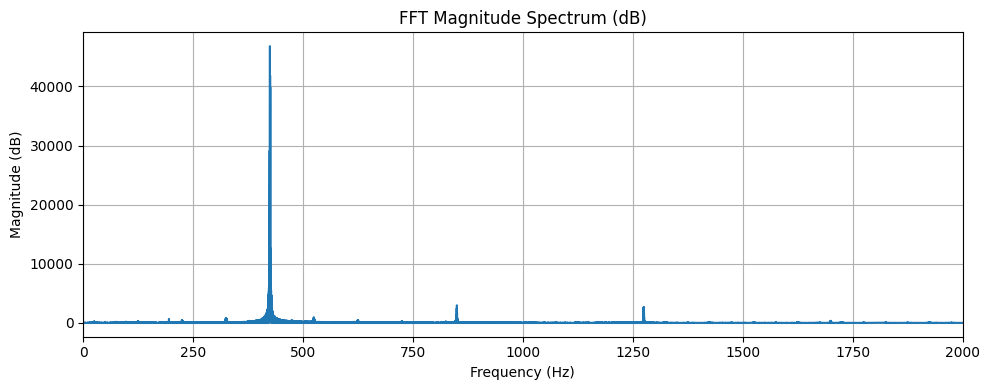

In [10]:
plt.figure(figsize=(10,4))
plt.plot(fft_freq, fft_magnitude)
plt.title("FFT Magnitude Spectrum (dB)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.xlim(0, 2000)
plt.tight_layout()
plt.show()

### Mencari frekuensi dominan dengan FFT

In [11]:
peaks, _ = find_peaks(fft_magnitude, height=np.max(fft_magnitude)*0.2)
dominant_fft_freq = fft_freq[peaks[np.argmax(fft_magnitude[peaks])]]

print("\nDominan Frequency (FFT):", np.round(dominant_fft_freq, 2), "Hz")


Dominan Frequency (FFT): 424.8 Hz


Visualisasi Frekuensi Dominan dengan FFT

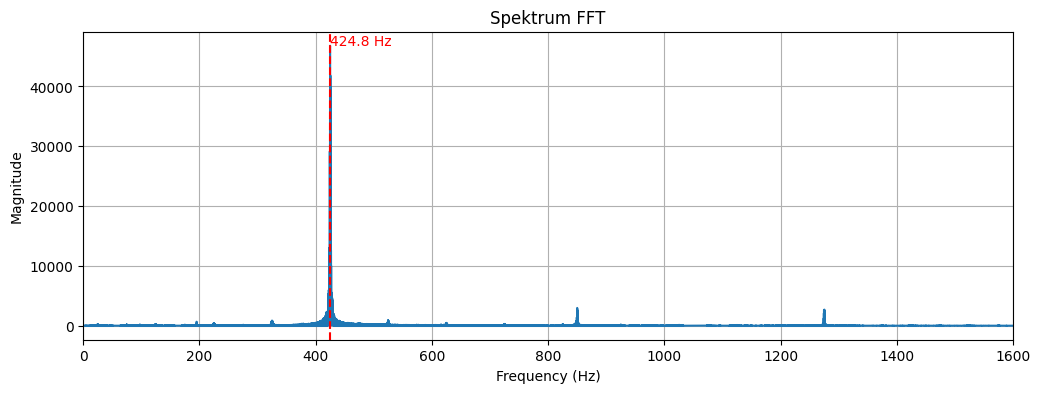

In [12]:
plt.figure(figsize=(12,4))
plt.plot(fft_freq, fft_magnitude)
plt.title("Spektrum FFT")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, sr/30)

# Penanda frekuensi dominan
plt.axvline(dominant_fft_freq, linestyle="--", color="red")
plt.text(dominant_fft_freq,
         np.max(fft_magnitude),
         f"{dominant_fft_freq:.1f} Hz",
         color="red")

plt.grid(True)
plt.show()

## Metode Goertzel (Pencarian frekuensi tertentu)

In [13]:
def goertzel(samples, sample_rate, target_freq):
    n = len(samples)
    k = int(0.5 + ((n * target_freq) / sample_rate))
    w = (2 * np.pi / n) * k
    cosine = np.cos(w)
    sine = np.sin(w)
    coeff = 2 * cosine
    q0, q1, q2 = 0, 0, 0
    for i in range(n):
        q0 = coeff * q1 - q2 + samples[i]
        q2 = q1
        q1 = q0
    real = q1 - q2 * cosine
    imag = q2 * sine

    return real + 1j * imag

In [14]:
# Cek Goertzel pada frekuensi umum audio
target_freqs = [200, 400, 500, 600, 800, 1000, 1500, 2000]

results = []

print("\nAnalisis Frekuensi (Goertzel)")
for f in target_freqs:
    value = goertzel(clean_audio, sr, f)

    mag = np.abs(value) / len(clean_audio)                      
    mag_db = 20 * np.log10(mag + 1e-12)         

    results.append([f, mag, mag_db])

    print(f"{f} Hz : {value}, Mag: {mag:.4f}, dB: {mag_db:.2f}")


Analisis Frekuensi (Goertzel)
200 Hz : (-34.50332425461227+17.167208480891663j), Mag: 0.0000, dB: -97.62
400 Hz : (7.396930601968052+198.04701056802045j), Mag: 0.0001, dB: -83.40
500 Hz : (23.640141670825642+32.28607448051777j), Mag: 0.0000, dB: -97.30
600 Hz : (-50.06232009236135+27.04768690408299j), Mag: 0.0000, dB: -94.24
800 Hz : (-2.29640313343117-17.881775488304708j), Mag: 0.0000, dB: -104.22
1000 Hz : (20.82376108985614+5.3508515894561866j), Mag: 0.0000, dB: -102.69
1500 Hz : (-3.9351101622207807-1.1729573065068473j), Mag: 0.0000, dB: -117.07
2000 Hz : (-1.8695693747614568-1.4524181833140457j), Mag: 0.0000, dB: -121.85


In [15]:
df_goertzel = pd.DataFrame(results, columns=["freq", "magnitude_linier", "magnitude_dB"])
freq_dom_goertzel = df_goertzel.loc[df_goertzel["magnitude_linier"].idxmax(), "freq"]
print("\nDataFrame hasil Goertzel:")
print(df_goertzel)


DataFrame hasil Goertzel:
   freq  magnitude_linier  magnitude_dB
0   200      1.314902e-05    -97.622133
1   400      6.761966e-05    -83.398541
2   500      1.365310e-05    -97.295377
3   600      1.941457e-05    -94.237442
4   800      6.151267e-06   -104.220707
5  1000      7.335765e-06   -102.691090
6  1500      1.401014e-06   -117.071142
7  2000      8.077600e-07   -121.854342


Visualisasi Spectrum Goertzel

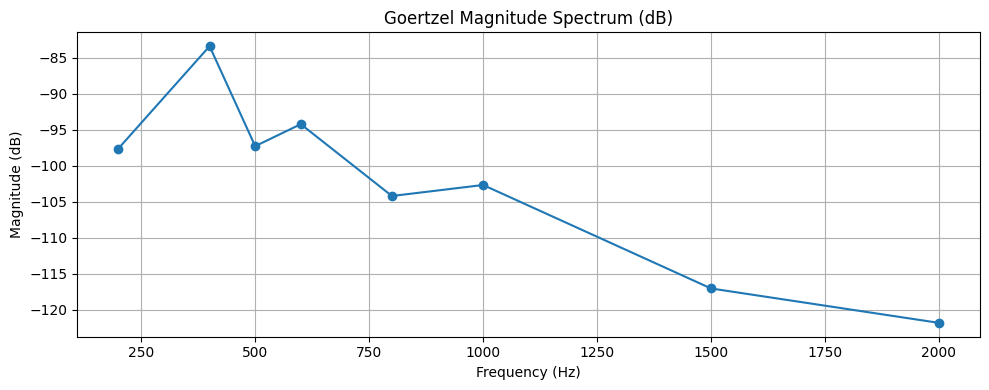

In [16]:
plt.figure(figsize=(10,4))
plt.plot(df_goertzel["freq"], df_goertzel["magnitude_dB"], marker='o')
plt.title("Goertzel Magnitude Spectrum (dB)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Mencari frekuensi dominan dengan Goertzel

In [17]:
dominant_index = np.argmax(df_goertzel["magnitude_dB"])
dominant_freq = df_goertzel.iloc[dominant_index]["freq"]

print("\nFrekuensi Dominan (Goertzel):", dominant_freq, "Hz")


Frekuensi Dominan (Goertzel): 400.0 Hz


Visualisasi frekuensi dominan dengan goertzel

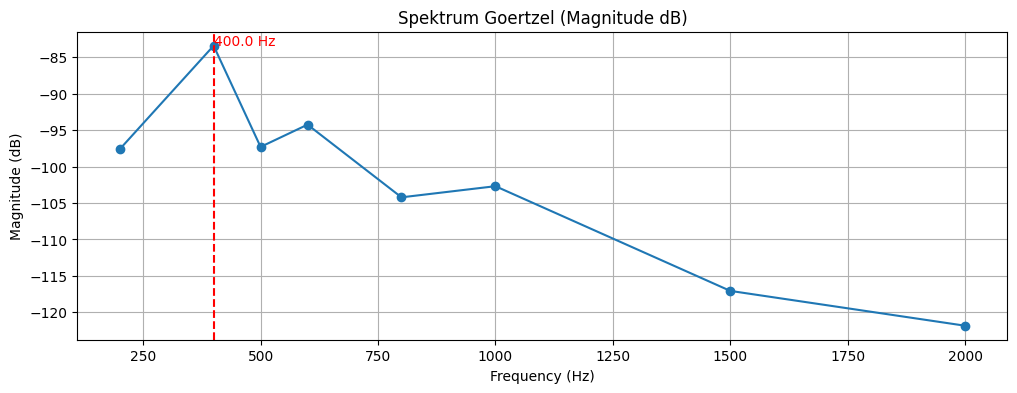

In [18]:
plt.figure(figsize=(12,4))
plt.plot(df_goertzel["freq"], df_goertzel["magnitude_dB"], marker='o')
plt.title("Spektrum Goertzel (Magnitude dB)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)

# gaya anotasi dominan
plt.axvline(dominant_freq, linestyle='--', color='red')
plt.text(dominant_freq,
         df_goertzel["magnitude_dB"].max(),
         f"{dominant_freq:.1f} Hz",
         color='red')

plt.show()

## Perbandingan Frekuensi Dominan pada FFT dan Goertzel

In [19]:
print("Magnitude FFT :", dominant_fft_freq)
print("Magnitude Goertzel :", dominant_freq)

Magnitude FFT : 424.7952833278742
Magnitude Goertzel : 400.0


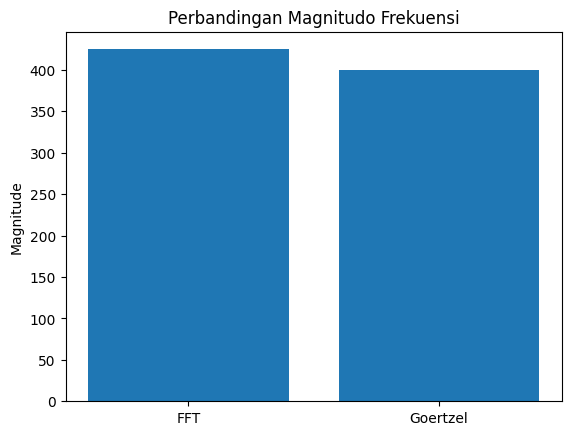

In [20]:
plt.bar(["FFT", "Goertzel"], [dominant_fft_freq, dominant_freq])
plt.ylabel("Magnitude")
plt.title("Perbandingan Magnitudo Frekuensi")
plt.show()

## Penyimpanan perbandingan

In [21]:
hasil_frekdominan = {
    "filename": "signal_call WA",
    "dominant_goertzel": dominant_freq,
    "dominant_fft": dominant_fft_freq
}

df_all = pd.DataFrame([hasil_frekdominan])

nama = hasil_frekdominan["filename"]
df_all.to_csv(f"hasil_{nama}.csv", index=False)
print(f"File tersimpan sebagai hasil_{nama}.csv")

File tersimpan sebagai hasil_signal_call WA.csv
